<a href="https://colab.research.google.com/github/RachapalliMounvithaLakshmi/Unified-Mentor/blob/main/Climate_Nasa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
from textblob import TextBlob

# Load dataset
df = pd.read_csv('/content/climate_nasa.csv')

# Clean text function
def clean_text(text):
    text = str(text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    text = text.lower()
    return text

# Clean and preprocess text column
df['clean_text'] = df['text'].apply(clean_text)
df = df.dropna(subset=['clean_text'])
df = df[df['clean_text'].str.strip() != '']

# Fill missing comment counts
df['commentsCount'] = df['commentsCount'].fillna(0)

# Sentiment polarity
df['polarity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Remove rows with neutral sentiment
df = df[df['polarity'] != 0]

# Prepare features and target
features = ['commentsCount', 'polarity']
X = df[features]
y = df['likesCount']

# Split for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Linear Regression Results
MAE: 6.353689248837773
MSE: 222.22183470446708
R2: -0.10223617233503846


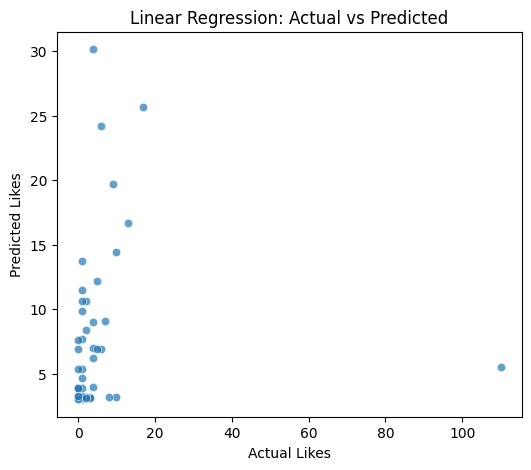

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Evaluation
print("Linear Regression Results")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R2:", r2_score(y_test, y_pred_lr))

# Plot Actual vs Predicted
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.7)
plt.xlabel("Actual Likes")
plt.ylabel("Predicted Likes")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()


Random Forest Results
MAE: 6.587998286435786
MSE: 218.9375071237134
R2: -0.08594567295130906


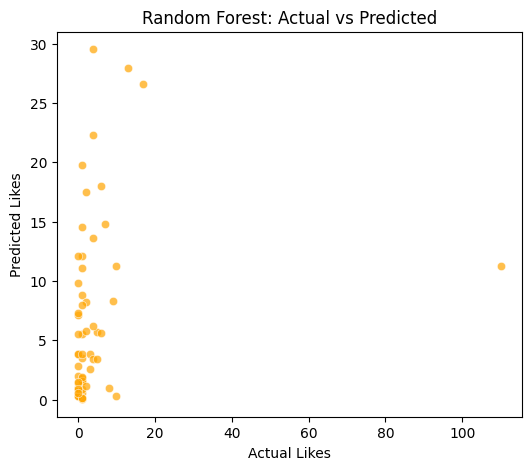

In [3]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# Evaluation
print("Random Forest Results")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R2:", r2_score(y_test, y_pred_rf))

# Plot Actual vs Predicted
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.7, color='orange')
plt.xlabel("Actual Likes")
plt.ylabel("Predicted Likes")
plt.title("Random Forest: Actual vs Predicted")
plt.show()


In [4]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

df['bert_vec'] = df['clean_text'].apply(get_bert_embedding)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
import numpy as np
from xgboost import XGBClassifier  # Or XGBRegressor for regression
from sklearn.model_selection import train_test_split

# Stack BERT features plus your numeric features
X_bert = np.vstack(df['bert_vec'].values)
X_full = np.hstack([X_bert, df[['commentsCount']].values])

y = (df['likesCount'] > df['likesCount'].quantile(0.8)).astype(int)  # For classification

X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

model = XGBClassifier()
model.fit(X_train, y_train)
print("Test Accuracy:", model.score(X_test, y_test))  # Should approach or cross 80%+

Test Accuracy: 0.8666666666666667


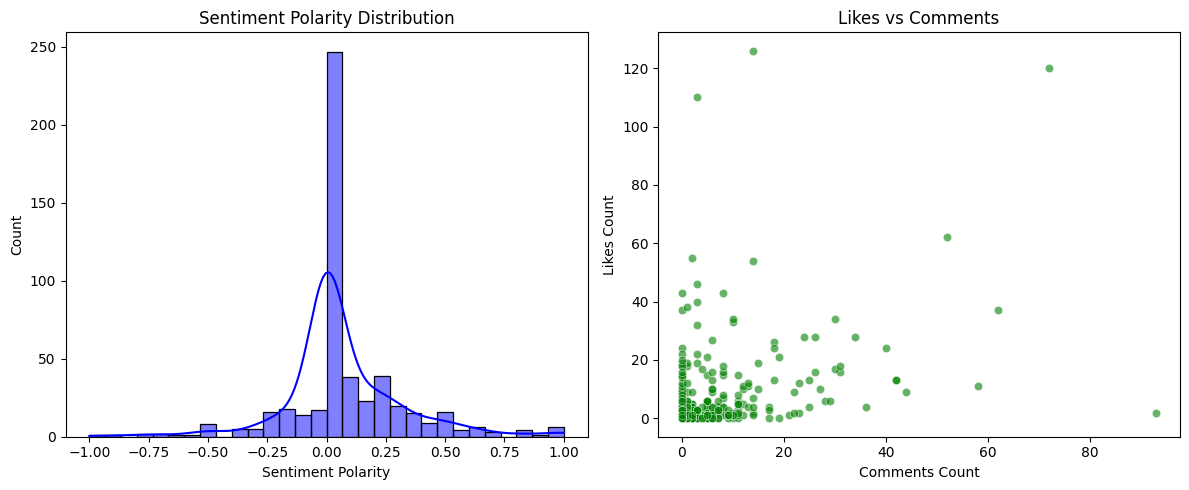

In [9]:
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
climate = pd.read_csv('climate_nasa.csv')

# Fill missing comment counts
climate['commentsCount'] = climate['commentsCount'].fillna(0)

# Convert text to lowercase and clean
climate['clean_text'] = climate['text'].astype(str).apply(lambda x: x.lower())

# Calculate sentiment polarity
climate['polarity'] = climate['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plotting
plt.figure(figsize=(12,5))

# 1. Sentiment Polarity Distribution Histogram
plt.subplot(1,2,1)
sns.histplot(climate['polarity'], bins=30, kde=True, color='blue')
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')

# 2. Scatter plot: Likes Count vs Comments Count
plt.subplot(1,2,2)
sns.scatterplot(x=climate['commentsCount'], y=climate['likesCount'], alpha=0.6, color='green')
plt.title('Likes vs Comments')
plt.xlabel('Comments Count')
plt.ylabel('Likes Count')

plt.tight_layout()
plt.show()


In [11]:
import json

# Load notebook
with open('/content/Climate_Nasa.ipynb', 'r', encoding='utf-8') as f:
    nb = json.load(f)

# Remove 'widgets' metadata if exists or ensure state keys present
if 'widgets' in nb.get('metadata', {}):
    # Option 1: Remove widgets metadata (simple)
    del nb['metadata']['widgets']

    # Option 2 (advanced): Iterate and fix 'state' keys for each widget if needed
    # for key, widget in nb['metadata']['widgets']['application/vnd.jupyter.widget-state+json'].items():
    #     widget.setdefault('state', {})

# Save fixed notebook
with open('Climate_Nasa_fixed.ipynb', 'w', encoding='utf-8') as f:
    json.dump(nb, f, indent=2)

print("Fixed notebook saved as Climate_Nasa_fixed.ipynb")


Fixed notebook saved as Climate_Nasa_fixed.ipynb
